# TODO
1. Error propagation through the mass flow calculation from gas velocity

# Cooling Tower Data Analysis
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.integrate as intgr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing

### Units
|  | Set Point Temp | Gas Flow | Liquid Flow | Outlet Water | Inlet Water | Outlet Air - Dry Bulb | Outlet Air - Wet Bulb | Inlet Air - Wet Bulb | Inlet Air - Dry Bulb |
|--------|----------------|----------|-------------|--------------|-------------|-----------------------|-----------------------|----------------------|----------------------|
| Raw | $^\circ$ C | m/s | gal/min | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C |
| Desired | $^\circ$ C | kg/s | kg/s | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C |

Most units can be readily converted to the desired output, with the exception of gas flow. Converting gas flow in m/s to kg/s requires the find the density of the inlet air, which is humid.

Perry's Handbook: Find saturation vapor pressure $p_{wb}$ at wet-bulb temperature $T_{wb}$ from Eq. (12-4). Find actual vapor
pressure $p$ at dry-bulb temperature $T$ from psychrometer equation (12-11). Find humid air density $\rho_g$ by
conversion from $p$ and $T$ (Table 12-2). All units in SI.

**12-4:** $\ln p_{wb} = −6096.9385T_{wb}^{−1} + 21.2409642 − 2.711193\times10^{−2}T_{wb} + 1.673952\times10^{−5}T_{wb}^2 + 2.433502 \ln T_{wb}$

where $T_{wb}$ is in Kelvin, $p_{wb}$ is in pascals.

**12-11:** $p = p_{wb} − AP(T − T_{wb})$

where $A$ is the psychrometric coefficient and $P$ is atmosphere pressure in Pa.

**12-11a:** $A = 6.5\times10^{−4}(1 + 0.000944T_{wb})$

Eq. 12-11a is valid for $T_{wb}$ up to 30 $^\circ$C.

**Table 12-2**: $\rho_g = \frac{P-0.378p}{287.1T}$

where $\rho_g$ is the humid air density (kg/m^3).

For Day 1 of this lab, Feb. 12, 2020, atmospheric pressure $P$ was 30.12 "Hg.

In [2]:
def get_rho(T, T_wb):
    # T = Inlet Air - Dry Bulb [Kelvin]
    # T_wb = Inlet Air - Wet Bulb [Kelvin]
    # P = 30.12 "Hg on Day 1 = 101998.03 Pa
    T = T+273.15 # convert Celsius to Kelvin
    T_wb = T_wb+273.15 # convert...
    P = 101998.03
    p_wb = np.exp(-6096.9385*T_wb**-1 + \
                  21.2409642 - 2.711193*10**-2*T_wb + \
                  1.673952*10**-5*T**2 + \
                  2.433502*np.log(T_wb))
    A = 6.5*10**-4*(1 + 0.000944*T_wb)
    p = p_wb - A*P*(T - T_wb)
    rho = (P-0.378*p)/(287.1*T)
    return rho

def get_ma(v, T, T_wb):
    rho = get_rho(T, T_wb) # kg/m^3
    V = v*np.pi/4*0.095**2 # m^3/s
    return rho*V # kg/s

### Error propagation functions

In [3]:
def Terr(T):
    return np.where(0.04*T > 0.5, 0.04*T, 0.5)

def Lerr(L):
    return 0.02*2

def Gerr(G):
    return np.where(0.03*G > 0.2, 0.03*G, 0.2)

def LGerr(L, G, dL, dG):
    # LG = L/G => 1/G, -L/G^2
    pL = 1/G
    pG = -1*L/G**2
    return np.sqrt(pL**2*dL**2 + pG**2*dG**2)

# def Gerr2(v, T, T_wb):
#     

### Import and clean data
I had combined all the data from day 1 and added two columns, Group and Trial. These columns ended up being trivial as the liquid flow sufficed to group the data. I then aggregated by liquid flow and calculated means and standard deviations, compiling these values in a new dataframe.
### Get error
Used larger of two between instrument error and standard deviation of measurements.

In [4]:
df = pd.read_csv("Cooling Tower Day 1 - All.csv")
df_all = df.copy()

# Drop extra columns
df = df.drop(columns=['Group', 'Trial'])
df_all = df_all.drop(columns=['Group', 'Trial'])

# Aggregate for mean and err
df_mean = df.groupby(['Set Point Temp','Gas Flow', 'Liquid Flow']).agg('mean').reset_index(drop=True)
df_err = df.groupby(['Set Point Temp','Gas Flow', 'Liquid Flow']).agg('std').reset_index(drop=True)
df_err = df_err.rename(lambda x: x+' - err', axis=1)

# Recombine
df = df[['Set Point Temp', 'Gas Flow', 'Liquid Flow']].drop_duplicates().reset_index()
df = pd.concat([df, df_mean, df_err], axis=1).drop(columns='index')

# Unit conversions
# Operating over a <20 degree range for water, therefore neglecting thermal expansion
df['Liquid Flow - err'] = df['Liquid Flow'].apply(Lerr)
df['Liquid Flow'] = df['Liquid Flow'].apply(lambda x: x*6.30902*10**-5*997)
df_all['Liquid Flow'] = df_all['Liquid Flow'].apply(lambda x: x*6.30902*10**-5*997)
df['Liquid Flow - err'] = df['Liquid Flow'].apply(lambda x: x*6.30902*10**-5*997)

df['Gas Flow - err'] = df['Gas Flow'].apply(Gerr)
df['Gas Flow'] = df.apply(lambda x: get_ma(x['Gas Flow'], x['Inlet Air - Dry Bulb'], x['Inlet Air - Wet Bulb']), axis=1)
df_all['Gas Flow'] = df_all.apply(lambda x: get_ma(x['Gas Flow'], x['Inlet Air - Dry Bulb'], x['Inlet Air - Wet Bulb']), axis=1)
df['Gas Flow - err'] = df.apply(lambda x: get_ma(x['Gas Flow - err'], x['Inlet Air - Dry Bulb'], x['Inlet Air - Wet Bulb']), axis=1)
df['L/G'] = df['Liquid Flow']/df['Gas Flow']
df_all['L/G'] = df_all['Liquid Flow']/df_all['Gas Flow']

# Getting correct error
meanlist = ['Outlet Water', 'Inlet Water', 'Outlet Air - Dry Bulb', 'Outlet Air - Wet Bulb', 'Inlet Air - Wet Bulb', 'Inlet Air - Dry Bulb']
errlist = ['Outlet Water - err', 'Inlet Water - err', 'Outlet Air - Dry Bulb - err', 'Outlet Air - Wet Bulb - err', 'Inlet Air - Wet Bulb - err', 'Inlet Air - Dry Bulb - err']
for mean, err in zip(meanlist, errlist):
    df[err] = np.where(Terr(df[mean]) > df[err], Terr(df[mean]), df[err])
df['L/G - err'] = LGerr(df['Liquid Flow'], df['Gas Flow'], df['Liquid Flow - err'], df['Gas Flow - err'])
# df.head()

### General equations
Defined as many functions as possible. i.e. Those that won't change.
* $hsat$: Enthalpy of saturated air, form for fit equation
* $Fah2Cel$: Convert Fahrenheit to Celsius
* $BTUpound2kJkg$: Convert $\frac{BTU}{lb}$ to $\frac{kJ}{kg}$

In [5]:
def hsat(T, a, b):
    return a*np.exp(b*T)
def Fah2Cel(T):
    return (T-32)*5/9
def BTUpound2kJkg(x):
    return x*2.326

### Fitting $hsat$ and plotting result

In [6]:
# Empirical/fit data
hs_T = np.array([40, 50, 60, 70, 80, 90, 100, 110, 120, 130]) # F
hs_h = np.array([15.230, 20.301, 26.46, 34.09, 43.69, 55.93, 71.73, 92.34, 119.54, 155.9]) # BTU/lb dry air

hs_T = Fah2Cel(hs_T)
hs_h = BTUpound2kJkg(hs_h)

# Fitting procedure
hsat_fit, hsat_cov = curve_fit(hsat, hs_T, hs_h, [0, 0])
fit_err = np.sqrt(np.diagonal(hsat_cov))

# Get fitted curve
hs_Tdata = np.linspace(hs_T[0], hs_T[-1], 100)
hs_hdata = hsat(hs_Tdata, *hsat_fit)
hs_h_errp = hsat(hs_Tdata, *hsat_fit+fit_err)
hs_h_errn = hsat(hs_Tdata, *hsat_fit-fit_err)

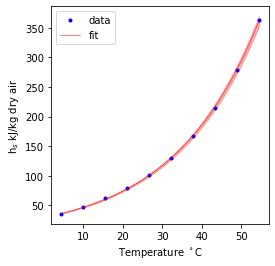

In [7]:
# Plot data and fitted curve
plt.figure(1)
plt.plot(hs_T, hs_h, 'b.')
plt.plot(hs_Tdata, hs_hdata, 'r-', linewidth=.5)
plt.xlabel('Temperature $^\circ$C')
plt.ylabel('h$_s$ kJ/kg dry air')
plt.legend(labels=['data', 'fit'])
plt.fill_between(hs_Tdata, hs_h_errp, hs_h_errn, color='r', alpha=0.3)
ax = plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio())
plt.savefig('Figures\hsat fit.png', dpi=300)

### Define air operating-line and Merkel equation
Now that $hsat$ is fitted, $enthalpy$ and $merkel$ can be defined

In [8]:
def enthalpy(T, Tin, Tout, LG):
    # Cp water = 4.182 kJ/kg C
    # Tout = Outlet water temperature [Celsius]
    # T = Water Temp [Celsius]
    # Tin = Wet bulb temperature in [Celsius]
    hin = hsat(Tin, *hsat_fit)
    h = hin + LG * 4.182 * (T-Tout)
    return h # [kJ/kg]
def merkel(T, Tin, Tout, LG):
    h = enthalpy(T, Tin, Tout, LG)
    hs = hsat(T, *hsat_fit)
    return 4.182/(hs-h)

### Calculate NTU and plot

In [9]:
g1 = df_all[df_all['Gas Flow'] < 0.017].reset_index()
g2 = df_all[(df_all['Gas Flow'] < 0.034) & (df_all['Gas Flow'] > 0.017)].reset_index()
g3 = df_all[(df_all['Gas Flow'] < 0.062) & (df_all['Gas Flow'] > 0.034)].reset_index()
for g in [g1, g2, g3]:
    NTU = g.apply(lambda x: intgr.quad(merkel, x['Outlet Water'], x['Inlet Water'],
                                 args=(x['Inlet Air - Wet Bulb'], x['Outlet Water'], x['L/G'])),
             axis=1)
    NTU = NTU.apply(lambda x: x[0])
    g['NTU'] = NTU.rolling(3).mean()
    g['NTU - err'] = NTU.rolling(3).std()
    
g1 = g1.loc[2::3].drop(columns='index').reset_index(drop=True)
g2 = g2.loc[2::3].drop(columns='index').reset_index(drop=True)
g3 = g3.loc[2::3].drop(columns='index').reset_index(drop=True)

In [10]:
g1err = df[df['Gas Flow'] < 0.017].reset_index(drop=True)
g2err = df[(df['Gas Flow'] < 0.034) & (df['Gas Flow'] > 0.017)].reset_index(drop=True)
g3err = df[(df['Gas Flow'] < 0.062) & (df['Gas Flow'] > 0.034)].reset_index(drop=True)

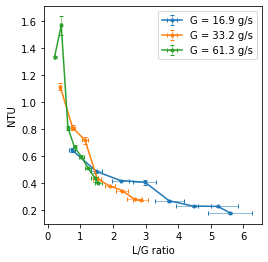

In [11]:
plt.figure(2)
for g_NTU, g in [(g1, g1err), (g2, g2err), (g3, g3err)]:
    plt.errorbar(g['L/G'], g_NTU['NTU'], g_NTU['NTU - err'], g['L/G - err'], marker='.', elinewidth=.5, capsize=2)
    plt.xlabel('L/G ratio')
    plt.ylabel('NTU')
plt.legend(labels=['G = 16.9 g/s', 'G = 33.2 g/s', 'G = 61.3 g/s'])
ax = plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio())
plt.savefig('Figures\Day 1 NTU.png', dpi=300)